In [14]:
# Copyright 2024 Mohammed Faizan
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [15]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import random
from collections import deque, namedtuple
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, ReLU, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.losses import MSE

In [16]:
# -------------------------
# 1. Data Loading and Preprocessing
# -------------------------

# Load the data with 'Date' as index (assuming first column is 'Date')
data = pd.read_csv('/datasets/reinforce_data/re_data.csv', index_col=0)
data.index = pd.to_datetime(data.index)

In [17]:
# List of features to normalize (excluding 'RSI' and 'CDF')
features_to_normalize = [
    'Nor_Adj_Close', 'MACD_Histogram', 'VWAP',
    '50_day_MA', '20_day_MA', '9_day_MA',
    'Skewness', 'Kurtosis', 'dynamic_rolling_variances'
    
]

# Split the data into training and validation sets
train_end_date = '2021-12-31'
val_end_date = '2022-12-31'

train_data = data[data.index <= train_end_date].copy()
val_data = data[(data.index > train_end_date) & (data.index <= val_end_date)].copy()

# Ensure there's no overlap
assert train_data.index.max() < val_data.index.min(), "Training and validation data overlap!"

# Normalize features using scalers fitted on training data
scaler = StandardScaler()
train_data[features_to_normalize] = scaler.fit_transform(train_data[features_to_normalize])
val_data[features_to_normalize] = scaler.transform(val_data[features_to_normalize])

# Reset indices but keep the date as a column
train_data.reset_index(inplace=True)
val_data.reset_index(inplace=True)
train_data.rename(columns={'index': 'Date'}, inplace=True)
val_data.rename(columns={'index': 'Date'}, inplace=True)

# Ensure 'Date' columns are datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])
val_data['Date'] = pd.to_datetime(val_data['Date'])

In [18]:
# -------------------------
# 2. Environment Definition
# -------------------------

class TradingEnv(gym.Env):
    def __init__(self, data, initial_balance=1000000, transaction_cost=0.000135, lookback_window=10):
        super(TradingEnv, self).__init__()

        # Dataset and parameters
        self.data = data
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        self.lookback_window = lookback_window

        # Define min and max percentage for episode length calculation
        self.min_percentage = 0.30  # Minimum percentage of remaining data
        self.max_percentage = 0.90  # Maximum percentage of remaining data

        # Environment state
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.current_step = 0
        self.current_position = None
        self.entry_price = None
        self.last_action = None  # Introduced to track the last action taken
        self.profit_target_reached = False
        self.trading_history = []

        # Action space: Buy, Hold, Sell
        self.action_space = gym.spaces.Discrete(3)
        
        # Dynamically determine the number of features in each timestep (based on the observation)
        self.n_features = len(self._get_observation())  # We can infer the number of features from one sample observation

        # Observation space: shape is (lookback_window, n_features), i.e., sequence of timesteps
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.lookback_window, self.n_features), dtype=np.float32
        )

        # Initialize a tracker to ensure each datapoint is covered
        self.datapoints_covered = np.zeros(len(self.data) - self.lookback_window, dtype=bool)
        
    def _get_observation(self, index=None):
        """
        Return a single observation (a feature vector) from the dataset.
        The observation corresponds to the timestep at the provided index,
        including internal state features.
        """
        if index is None:
            index = self.current_step
        if index >= len(self.data):
            raise ValueError("Current step exceeds the length of the data")

        current_data = self.data.iloc[index]

        # Construct the feature vector with the specified features
        observation = np.array([
            current_data['Nor_Adj_Close'],
            current_data['RSI'],
            current_data['MACD_Histogram'],
            current_data['VWAP'],
            current_data['Bollinger_Band_Width'],
            current_data['50_day_MA'],
            current_data['20_day_MA'],
            current_data['9_day_MA'],
            current_data['Skewness'],
            current_data['Kurtosis'],
            current_data['dynamic_rolling_variances'],
            current_data['CDF'],
            # Internal state features
            self.balance / self.initial_balance,  # Normalize balance
            self.stock_owned,
            self.last_action if self.last_action is not None else -1  # Last action taken (-1 if none)
        ], dtype=np.float32)

        return observation
        
    def _setup_timesteps(self, start_index):
        """
        Setup the number of timesteps for an episode, based on the start index and remaining data.
        Returns 0 if there are not enough sequences to form at least one timestep.
        """
        dataset_size = len(self.data)
        remaining_data = dataset_size - (start_index + 1)
        remaining_sequences = remaining_data - (self.lookback_window - 1)
        
        # Handle cases where remaining_sequences is less than 1
        if remaining_sequences < 1:
            return 0  # Indicates insufficient data for an episode
        
        # Calculate min and max timesteps based on percentages
        min_timesteps = max(1, int(remaining_sequences * self.min_percentage))
        max_timesteps = int(remaining_sequences * self.max_percentage)
        
        # Ensure max_timesteps is greater than min_timesteps
        if max_timesteps <= min_timesteps:
            max_timesteps = min_timesteps + 1  # To ensure randint has a valid range
        
        # Generate a random number of timesteps within the valid range
        num_timesteps = np.random.randint(min_timesteps, max_timesteps)
        
        # Ensure num_timesteps does not exceed remaining_sequences
        num_timesteps = min(num_timesteps, remaining_sequences)
        
        return num_timesteps

    def reset(self):
        """
        Reset the environment to the initial state and return the first sequence.
        Randomly select a starting point from uncovered datapoints.
        If no valid starting point is found, reset the tracker and attempt again.
        """
        # Reset environment variables
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.current_position = None
        self.entry_price = None
        self.trading_history = []
    
        # Attempt to find a valid starting point
        valid_start_found = False
        max_attempts = len(self.datapoints_covered)  # Prevent infinite loop
        attempts = 0
    
        while not valid_start_found and attempts < max_attempts:
            # Find all uncovered indices
            uncovered_indices = np.where(self.datapoints_covered == False)[0]
            
            if len(uncovered_indices) == 0:
                # All datapoints have been covered; reset the tracker
                self.datapoints_covered[:] = False
                uncovered_indices = np.where(self.datapoints_covered == False)[0]
                if len(uncovered_indices) == 0:
                    # Dataset is too small to form any sequences
                    raise ValueError("Dataset too small to form any sequences.")
            
            # Randomly select a starting point from the uncovered indices
            selected_index = np.random.choice(uncovered_indices)
            self.current_step = selected_index + (self.lookback_window - 1)
            
            # Set the number of timesteps for this episode
            self.num_timesteps = self._setup_timesteps(self.current_step)
            
            if self.num_timesteps > 0:
                # Valid starting point found
                valid_start_found = True
                
                # Mark the current sequence as covered
                start_cover = self.current_step - self.lookback_window + 1
                end_cover = self.current_step + 1  # Exclusive
                self.datapoints_covered[start_cover:end_cover] = True
                
                # Return the initial sequence (look back from the current_step)
                return self._get_sequence(self.current_step)
            else:
                # Insufficient data; mark this starting point as covered and skip
                self.datapoints_covered[selected_index] = True
                attempts += 1
                print(f"Skipping episode starting at index {selected_index} due to insufficient data.")
        
        # After all attempts, check if a valid start was found
        if not valid_start_found:
            # Reset the covered tracker and try again
            self.datapoints_covered[:] = False
            print("Resetting datapoints_covered tracker and attempting to reset again.")
            return self.reset

    def reset_eval(self):
        """
        Reset the environment to the initial state for evaluation/testing.
        Start from the beginning of the dataset.
        """
        # Reset environment variables
        self.balance = self.initial_balance
        self.stock_owned = 0
        self.current_position = None
        self.entry_price = None
        self.trading_history = []
        self.profit_target_reached = False  # For task completion reward

        # Start at the first valid step
        self.current_step = self.lookback_window - 1

        # Return the initial sequence
        return self._get_sequence(self.current_step)

    def _get_sequence(self, current_step):
        """
        Return a sequence of timesteps looking back from the current step.
        The sequence includes the current step and the previous lookback_window - 1 steps.
        """
        # Ensure the window is within bounds
        if current_step < self.lookback_window - 1:
            raise ValueError("Not enough data points to create the lookback window")

        # Define the start of the lookback window
        sequence_start = current_step - self.lookback_window + 1
        sequence_end = current_step + 1  # Include the current step

        # Collect the sequence
        sequence = []
        for i in range(sequence_start, sequence_end):
            observation = self._get_observation(i)  # Get the observation for each timestep
            sequence.append(observation)

        return np.array(sequence)

        return sequence.astype(np.float32)


    def step(self, action):
        """
        Take an action, calculate the reward, and return the next sequence.
        """
        # Record the current price
        current_price = self.data.iloc[self.current_step]['Adj Close']
        
        # Initialize variables
        reward = 0
        transaction_cost_value = 0
    
       
        # Scaling factors
        immediate_reward_scale = 1.0  # Scale for immediate rewards (e.g., price difference rewards)
        sharpe_ratio_scale = 100
        
        # Handle the actions: 0 = Sell, 1 = Hold, 2 = Buy
        if action == 2:  # Buy
            if self.stock_owned == 0:
                # Buy with 15% of balance (as before)
                max_shares = (self.balance * 0.10) / current_price
                if max_shares >= 1:
                    shares_to_buy = np.floor(max_shares)
                    total_purchase = shares_to_buy * current_price
                    transaction_cost_value = total_purchase * self.transaction_cost
                    total_cost = total_purchase + transaction_cost_value
                    self.stock_owned += shares_to_buy
                    self.balance -= total_cost
                    self.entry_price = current_price  # Track the purchase price
                    
                    # No reward or penalty for buying; just tracking the position
                    reward = 0 
                else:
                    # penalty for overspending 
                    reward -= 10 * immediate_reward_scale
            else:
                # penalizing for repitative buying 
                reward -= 10 * immediate_reward_scale
    
        elif action == 1:  # Hold
            if self.stock_owned > 0:
                # Calculate the difference between the current price and the entry price
                price_difference = current_price - self.entry_price
                reward = price_difference * self.stock_owned  # Reward is profit or loss on held stock
    
                # Scale the immediate reward
                reward *= immediate_reward_scale
    
            else:
                # penalty for holding with out stock held
                reward -= 10 * immediate_reward_scale
    
        elif action == 0:  # Sell
            if self.stock_owned > 0:
                # Calculate profit or loss based on sell price and buy price
                price_difference = current_price - self.entry_price
                reward = price_difference * self.stock_owned  # Reward is profit or loss on sold stock
    
                # Sell all shares
                gross_sell_value = self.stock_owned * current_price
                transaction_cost_value = gross_sell_value * self.transaction_cost
                net_sell_value = gross_sell_value - transaction_cost_value
                self.balance += net_sell_value
                self.stock_owned = 0
                self.entry_price = None
    
                # Scale the immediate reward
                reward *= immediate_reward_scale
    
            else:
                # Penalty for attempting to sell without holding any stock
                reward -= 10 * immediate_reward_scale  # Penalty remains the same
    
        # Update last action
        self.last_action = action
    
        # Move the step forward
        self.current_step += 1
    
        # Update net worth
        current_net_worth = self.balance + self.stock_owned * current_price
    
        # Set reward to zero for the buy action (no immediate feedback for buy)
        if action == 2:
            reward = 0  # No reward for buying
    
        # Check if we're done
        done = self.current_step >= len(self.data) - 1
    
        # If done, liquidate any remaining stock holdings
        if done and self.stock_owned > 0:
            # Sell all shares at current price
            gross_sell_value = self.stock_owned * current_price
            transaction_cost_value = gross_sell_value * self.transaction_cost
            net_sell_value = gross_sell_value - transaction_cost_value
            self.balance += net_sell_value
            self.stock_owned = 0
            self.entry_price = None
            # Update net worth
            current_net_worth = self.balance
    
        # If done (end of the episode), calculate Sharpe Ratio and add it as a scaled reward
        if done:
            historical_net_worth = [entry['portfolio_value'] for entry in self.trading_history]
            returns = np.diff(historical_net_worth)
            sharpe_ratio = self.calculate_sharpe_ratio(returns)
    
            # Scale the Sharpe Ratio to make it comparable to immediate rewards
            scaled_sharpe_ratio = sharpe_ratio * sharpe_ratio_scale  # Example scaling factor
    
            # Add the scaled Sharpe Ratio as a final bonus reward
            reward += scaled_sharpe_ratio
    
        # Task completion reward (10% total return)
        if not self.profit_target_reached and current_net_worth >= self.initial_balance * 1.10:
            # Calculate bonus as 10% of profit
            profit = current_net_worth - self.initial_balance
            bonus_reward = profit * 0.10
            reward += bonus_reward
            self.profit_target_reached = True
    
        # Log the trading history
        self.trading_history.append({
            'step': self.current_step,
            'current_price': current_price,
            'balance': self.balance,
            'portfolio_value': current_net_worth,
            'reward': reward,
            'action': action
        })
    
        # Get the next sequence after the action
        if not done:
            next_sequence = self._get_sequence(self.current_step)
        else:
            # Ensure next_sequence is a NumPy array of the correct shape filled with zeros
            next_sequence = np.zeros_like(self._get_sequence(self.current_step - 1))
    
        return next_sequence, reward, done, {"portfolio_value": current_net_worth}
    
    def calculate_sharpe_ratio(self, returns, risk_free_rate=0.02):
        """
        Calculate the Sharpe ratio based on the returns.
        """
        excess_returns = returns - risk_free_rate
        sharpe_ratio = np.mean(excess_returns) / (np.std(excess_returns) + 1e-9)
        return sharpe_ratio




    def render(self, mode='human'):
        """
        Render plots showing the portfolio value, rewards, and actions over the episode.
        """
        if len(self.trading_history) == 0:
            print("No trading history available for this episode.")
            return
    
        # Extract relevant data from trading history
        steps = [entry['step'] for entry in self.trading_history]
        portfolio_values = [entry['portfolio_value'] for entry in self.trading_history]
        rewards = [entry['reward'] for entry in self.trading_history]
        prices = [entry['current_price'] for entry in self.trading_history]
    
        # Extract actions from trading_history
        actions = [entry.get('action', None) for entry in self.trading_history]
    
        # Create a figure with three subplots
        fig, axs = plt.subplots(3, 1, figsize=(12, 15))
    
        # Plot 1: Portfolio Value Over Time
        axs[0].plot(steps, portfolio_values, label='Portfolio Value', color='blue')
        axs[0].set_title('Portfolio Value Over Time')
        axs[0].set_xlabel('Timestep')
        axs[0].set_ylabel('Portfolio Value (INR)')
        axs[0].legend()
        axs[0].grid(True)
    
        # Plot 2: Rewards Over Time
        cumulative_rewards = np.cumsum(rewards)
        axs[1].plot(steps, rewards, label='Reward', color='orange')
        axs[1].plot(steps, cumulative_rewards, label='Cumulative Reward', color='green', linestyle='--')
        axs[1].set_title('Rewards Over Time')
        axs[1].set_xlabel('Timestep')
        axs[1].set_ylabel('Reward')
        axs[1].legend()
        axs[1].grid(True)
    
        # Plot 3: Price and Actions Over Time
        axs[2].plot(steps, prices, label='Price', color='black')
        
        # Extract actions for Buy, Sell, and Hold
        buy_steps = [step for step, action in zip(steps, actions) if action == 2]
        buy_prices = [price for price, action in zip(prices, actions) if action == 2]
        sell_steps = [step for step, action in zip(steps, actions) if action == 0]
        sell_prices = [price for price, action in zip(prices, actions) if action == 0]
        hold_steps = [step for step, action in zip(steps, actions) if action == 1]
        hold_prices = [price for price, action in zip(prices, actions) if action == 1]
    
        # Scatter plot for Buy, Sell, and Hold actions
        axs[2].scatter(buy_steps, buy_prices, marker='^', color='green', label='Buy', s=100)
        axs[2].scatter(sell_steps, sell_prices, marker='v', color='red', label='Sell', s=100)
        axs[2].scatter(hold_steps, hold_prices, marker='o', color='blue', label='Hold', s=25)  # Hold action added
    
        axs[2].set_title('Price and Actions Over Time')
        axs[2].set_xlabel('Timestep')
        axs[2].set_ylabel('Price (INR)')
        axs[2].legend()
        axs[2].grid(True)
    
        # Adjust layout
        plt.tight_layout()
        plt.show()

In [19]:
# SumTree implementation for Prioritized Experience Replay
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity  # Number of leaf nodes (experiences)
        self.tree = np.zeros(2 * capacity - 1)  # Binary tree array
        self.data = np.zeros(capacity, dtype=object)  # Experience storage
        self.size = 0
        self.data_pointer = 0

    def add(self, priority, data):
        # Add experience with given priority
        idx = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        self.update(idx, priority)

        self.data_pointer += 1
        if self.data_pointer >= self.capacity:  # Replace when full
            self.data_pointer = 0

        # Update the size, max at capacity
        self.size = min(self.size + 1, self.capacity)

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority

        while idx != 0:  # Propagate the change up the tree
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get_leaf(self, value):
        parent_idx = 0
        while True:  # Traverse the tree to find the leaf
            left_child_idx = 2 * parent_idx + 1
            right_child_idx = left_child_idx + 1

            if left_child_idx >= len(self.tree):  # Leaf node
                leaf_idx = parent_idx
                break
            else:
                if value <= self.tree[left_child_idx]:
                    parent_idx = left_child_idx
                else:
                    value -= self.tree[left_child_idx]
                    parent_idx = right_child_idx

        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    def total_priority(self):
        return self.tree[0]  # Root node

In [20]:
# Define the named tuple for experience
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

# Setting up the environments
env = TradingEnv(train_data)
val_env = TradingEnv(val_data)
num_episodes = 550  # Adjust the number of episodes as needed

# Create the replay buffer using the SumTree class
MEMORY_SIZE = 50000
memory_buffer = SumTree(capacity=MEMORY_SIZE) 
alpha = 0.6  # Prioritization exponent

# Initialize beta parameters for importance-sampling weights
beta_start = 0.4  # Starting value for beta
beta_end = 1.0  # Final value for beta
beta_increment_per_episode = (beta_end - beta_start) / num_episodes

# Initialize beta
beta = beta_start

In [21]:
def store_experience(memory_buffer, exp):
    """
    Stores an experience tuple in the replay buffer.
    """
    # Get the maximum current priority from the leaf nodes
    max_priority = np.max(memory_buffer.tree[-memory_buffer.capacity:]) if memory_buffer.size > 0 else 1.0

    # Add the new experience to the memory buffer with the max priority
    memory_buffer.add(max_priority, exp)

def sample_experiences(memory_buffer, batch_size, beta):
    current_size = memory_buffer.size
    actual_batch_size = min(batch_size, current_size)

    experiences = []
    indexes = []
    priorities = []

    total_priority = memory_buffer.total_priority()

    if total_priority == 0:
        print("Total priority is zero, cannot sample experiences.")
        return None, None, None

    segment = total_priority / actual_batch_size  # Divide total priority into equal segments

    for i in range(actual_batch_size):
        a = segment * i
        b = segment * (i + 1)

        # Sample a value within the segment
        s = np.random.uniform(a, b)
        idx, priority, experience = memory_buffer.get_leaf(s)

        experiences.append(experience)
        indexes.append(idx)
        priorities.append(priority)

    # Extract components from experiences
    states = np.array([e.state for e in experiences], dtype=np.float32)
    actions = np.array([e.action for e in experiences], dtype=np.int32)
    rewards = np.array([e.reward for e in experiences], dtype=np.float32)
    next_states = np.array([e.next_state for e in experiences], dtype=np.float32)
    dones = np.array([e.done for e in experiences], dtype=np.float32)

    # Calculate Importance-Sampling (IS) weights
    sampling_probabilities = priorities / total_priority
    is_weights = np.power(current_size * sampling_probabilities, -beta)
    is_weights /= is_weights.max()  # Normalize IS weights

    # Convert to tensors
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
    next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
    dones = tf.convert_to_tensor(dones, dtype=tf.float32)
    is_weights = tf.convert_to_tensor(is_weights, dtype=tf.float32)

    return (states, actions, rewards, next_states, dones), indexes, is_weights

In [22]:
def get_action(state, epsilon, model):
    """
    Chooses an action based on the epsilon-greedy strategy, using the provided model.
    """
    if np.random.rand() <= epsilon:
        return random.choice([0, 1, 2])
    else:
        state = np.expand_dims(state, axis=0)  # Shape: (1, lookback_window, n_features)
        q_values = model(state)
        return np.argmax(q_values.numpy()[0])
    
def compute_td_error(q_network, target_q_network, experiences, gamma):
    """Computes the TD error for a batch of experiences."""
    states, actions, rewards, next_states, dones = experiences

    # Compute target Q-values
    q_next = target_q_network(next_states)
    max_q_next = tf.reduce_max(q_next, axis=1)
    y_targets = rewards + gamma * max_q_next * (1 - dones)

    # Compute current Q-values
    q_values = q_network(states)
    indices = tf.stack([tf.range(q_values.shape[0]), actions], axis=1)
    q_values_taken = tf.gather_nd(q_values, indices)

    # TD Errors
    td_errors = y_targets - q_values_taken
    return td_errors.numpy()

def update_priorities(memory_buffer, indexes, td_errors, alpha=alpha):
    """
    Updates the priorities of sampled experiences in the replay buffer.
    """
    for idx, td_error in zip(indexes, td_errors):
        priority = (np.abs(td_error) + 1e-5) ** alpha
        memory_buffer.update(idx, priority)

def compute_loss(experiences, gamma, q_network, target_q_network,is_weights):
    

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Calculate the loss
    loss = MSE(y_targets, q_values)
    
    # Apply importance-sampling weights
    weighted_loss = loss * is_weights

    # Return the mean weighted loss
    return tf.reduce_mean(weighted_loss)

@tf.function
def agent_learn(experiences, gamma, is_weights):
    """
    Updates the weights of the Q networks.
    """
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network, is_weights)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # Update the weights of target q_network
    update_target_network(q_network, target_q_network)
    
def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(
        target_q_network.weights, q_network.weights
    ):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and  memory_buffer.size >= batch_size:
        return True
    else:
        return False

def evaluate_model(env, model):
    """
    Evaluates the model on the entire environment and returns the total reward and final portfolio value.
    """
    # Reset environment in evaluation mode (start from the first sequence)
    state = env.reset_eval()
    total_reward_val = 0
    done = False
    final_portfolio_value = env.initial_balance  # Initialize with the initial balance

    # Loop until the end of the dataset
    while not done:
        # Exploit (no exploration during evaluation, always use the best predicted action)
        action = get_action(state, epsilon=0, model=model)

        # Perform the action and observe the next state, reward, and done signal
        next_state, reward, done, info = env.step(action)

        # Update total reward and portfolio value
        total_reward_val += reward
        final_portfolio_value = info['portfolio_value']

        # Move to the next state
        state = next_state

    return total_reward_val, final_portfolio_value

In [23]:
# -------------------------
# 4. Network Architecture and Training Hyperparameters
# -------------------------

# Access the parameters from the environment
lookback_window = env.lookback_window
n_features = env.n_features
num_actions = env.action_space.n

# Set the random seed for TensorFlow
SEED = 0 
tf.random.set_seed(SEED)

# Define regularization and dropout parameters
regularization_term = l2(0.003)
dropout_rate = 0.1

def create_model():
    model = Sequential([
        Input(shape=(lookback_window, n_features)),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=regularization_term)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=regularization_term)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Bidirectional(LSTM(16, return_sequences=False, kernel_regularizer=regularization_term)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=regularization_term),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=regularization_term),
        Dropout(dropout_rate),
        Dense(num_actions, activation='linear')
    ])
    return model


# Create the Q-network and target Q-network
q_network = create_model()
target_q_network = create_model()
target_q_network.set_weights(q_network.get_weights())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)

In [24]:
# Updated Hyperparameters
batch_size = 256
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995 # Changed Confirmation
epsilon_min = 0.1
NUM_STEPS_FOR_UPDATE =4 
TAU = 1e-2
acceptable_drawdown = 0.15
render_interval = 100
evaluation_interval = 10

# Initialize dynamic early stopping parameters
best_val_reward = -np.inf
episodes_without_improvement = 0
dynamic_patience = int(0.2 * num_episodes)

2024-10-17 07:37:35.109652: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efd991dd5a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-17 07:37:35.109689: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-10-17 07:37:35.129286: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1729150655.248207     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode 10: Validation Reward = 4119.459740274123, Training Reward = -26828.90478515625
Episode 10: Validation Percentage Return = 0.54%
Episode 20: Validation Reward = 3902.097255953965, Training Reward = 15706.47705078125
Episode 20: Validation Percentage Return = 0.46%
Episode 30: Validation Reward = 1997.1368435359032, Training Reward = -4236.22509765625
Episode 30: Validation Percentage Return = 0.35%
Episode 40: Validation Reward = 5452.549887016262, Training Reward = 2647.828125
Episode 40: Validation Percentage Return = 0.69%
Episode 50: Validation Reward = -390808.2825880287, Training Reward = 196210.7490234375
Episode 50: Validation Percentage Return = -0.03%
Episode 60: Validation Reward = -405039.2049846555, Training Reward = 72992.287109375
Episode 60: Validation Percentage Return = 0.04%
Episode 70: Validation Reward = 96676.76724905902, Training Reward = 25826.005859375
Episode 70: Validation Percentage Return = 0.49%
Episode 80: Validation Reward = -100115.12005615274, 

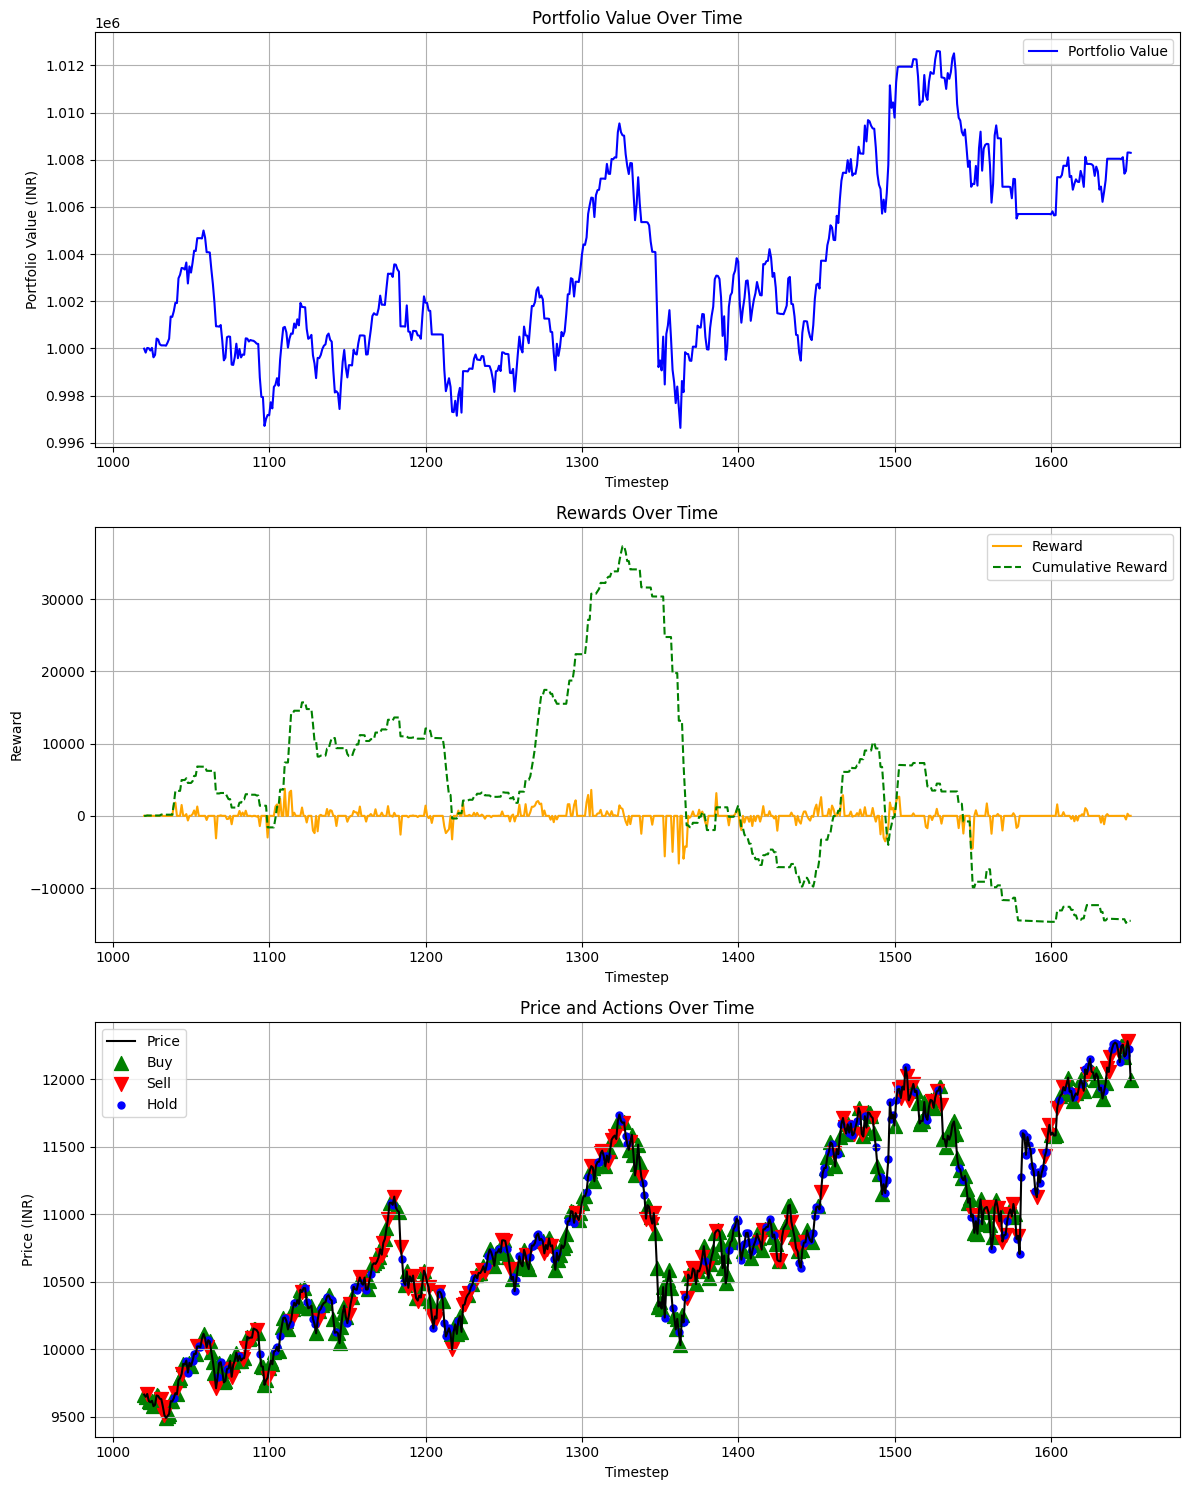

Episode 110: Validation Reward = 36069.93619437152, Training Reward = 140743.8486328125
Episode 110: Validation Percentage Return = 0.49%
Episode 120: Validation Reward = -211861.60931396525, Training Reward = 203058.3125
Episode 120: Validation Percentage Return = 0.33%
Episode 130: Validation Reward = -469.30208687848426, Training Reward = 168748.6884765625
Episode 130: Validation Percentage Return = 0.49%
Episode 140: Validation Reward = -295391.48724365275, Training Reward = -62214.1865234375
Episode 140: Validation Percentage Return = 0.33%
Episode 150: Validation Reward = -618278.9490418073, Training Reward = 131271.9833984375
Episode 150: Validation Percentage Return = 0.12%
Episode 160: Validation Reward = -474368.65654619265, Training Reward = 154965.77490234375
Episode 160: Validation Percentage Return = 0.21%
Episode 170: Validation Reward = 1356450.303345828, Training Reward = 174227.5830078125
Episode 170: Validation Percentage Return = 1.39%
Episode 180: Validation Reward

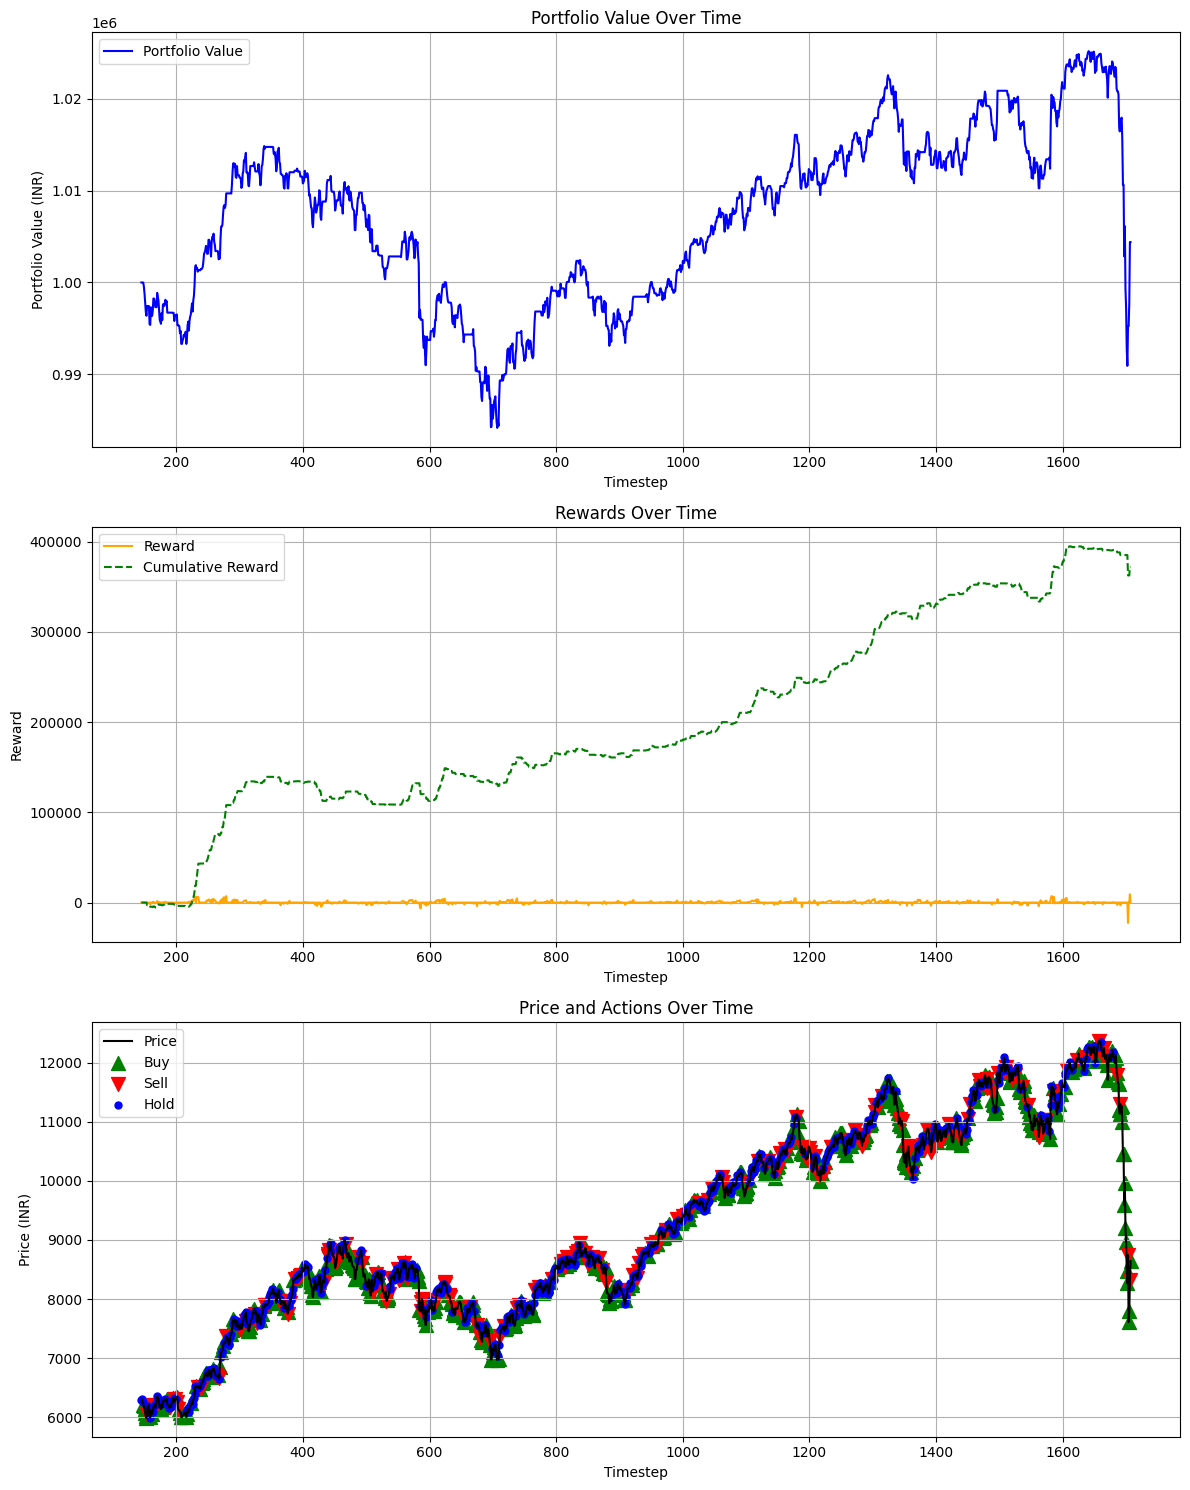

Episode 210: Validation Reward = -483575.8265333412, Training Reward = 39816.568359375
Episode 210: Validation Percentage Return = -0.03%
Episode 220: Validation Reward = -472190.3333692787, Training Reward = -950.99609375
Episode 220: Validation Percentage Return = -0.03%
Episode 230: Validation Reward = -467357.3109083412, Training Reward = -11156.748046875
Episode 230: Validation Percentage Return = -0.03%
Episode 240: Validation Reward = -239360.5726270912, Training Reward = -54875.482421875
Episode 240: Validation Percentage Return = -0.03%
Episode 250: Validation Reward = -257988.3070020912, Training Reward = 11474.994140625
Episode 250: Validation Percentage Return = -0.03%
Episode 260: Validation Reward = -273166.5687208412, Training Reward = 90624.8603515625
Episode 260: Validation Percentage Return = -0.03%
Episode 270: Validation Reward = -276777.5696974037, Training Reward = 222164.7216796875
Episode 270: Validation Percentage Return = -0.03%
Episode 280: Validation Reward 

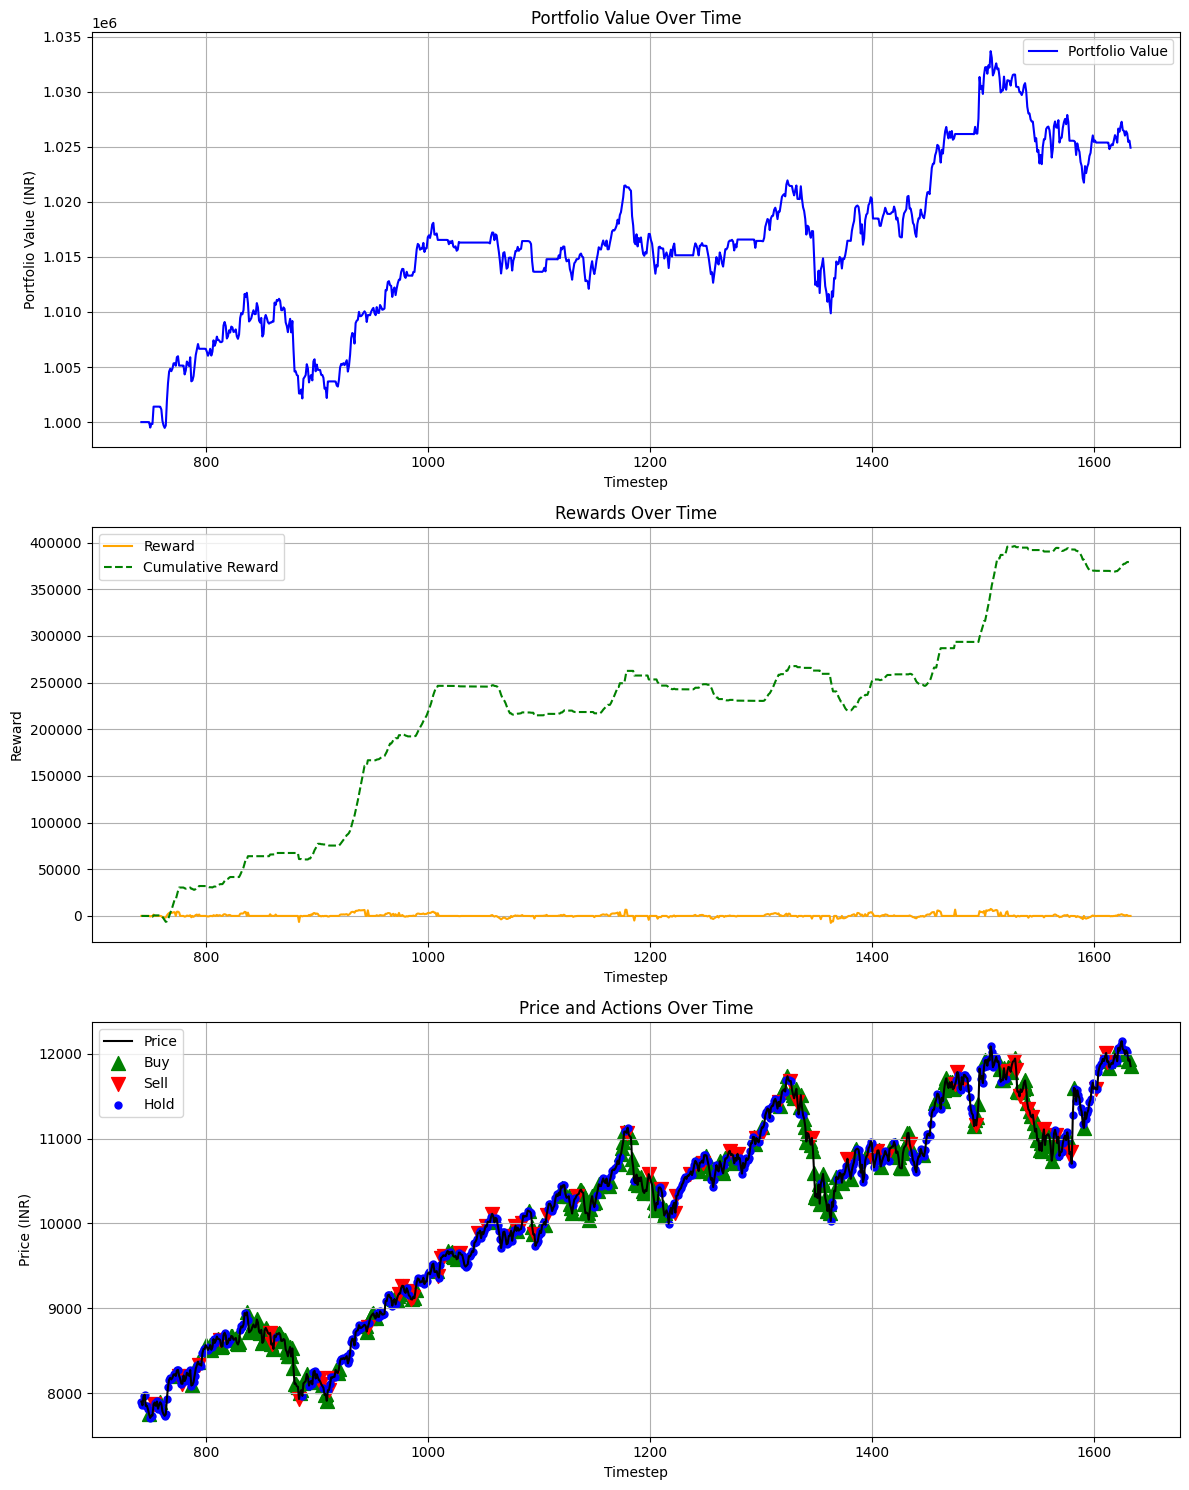

Episode 310: Validation Reward = -77488.29723646621, Training Reward = 414016.6884765625
Episode 310: Validation Percentage Return = -0.03%
Episode 320: Validation Reward = -76307.55504896621, Training Reward = 158244.76611328125
Episode 320: Validation Percentage Return = -0.03%
Episode 330: Validation Reward = -31901.056025528713, Training Reward = 7587.810546875
Episode 330: Validation Percentage Return = -0.03%
Episode 340: Validation Reward = -13341.300166153711, Training Reward = 342604.431640625
Episode 340: Validation Percentage Return = -0.03%
Episode 350: Validation Reward = -11070.050166153711, Training Reward = 57160.6767578125
Episode 350: Validation Percentage Return = -0.03%
Episode 360: Validation Reward = -177990.5677442787, Training Reward = 12592.384765625
Episode 360: Validation Percentage Return = -0.03%
Episode 370: Validation Reward = -227688.3118849037, Training Reward = 410874.109375
Episode 370: Validation Percentage Return = -0.03%
Episode 380: Validation Rew

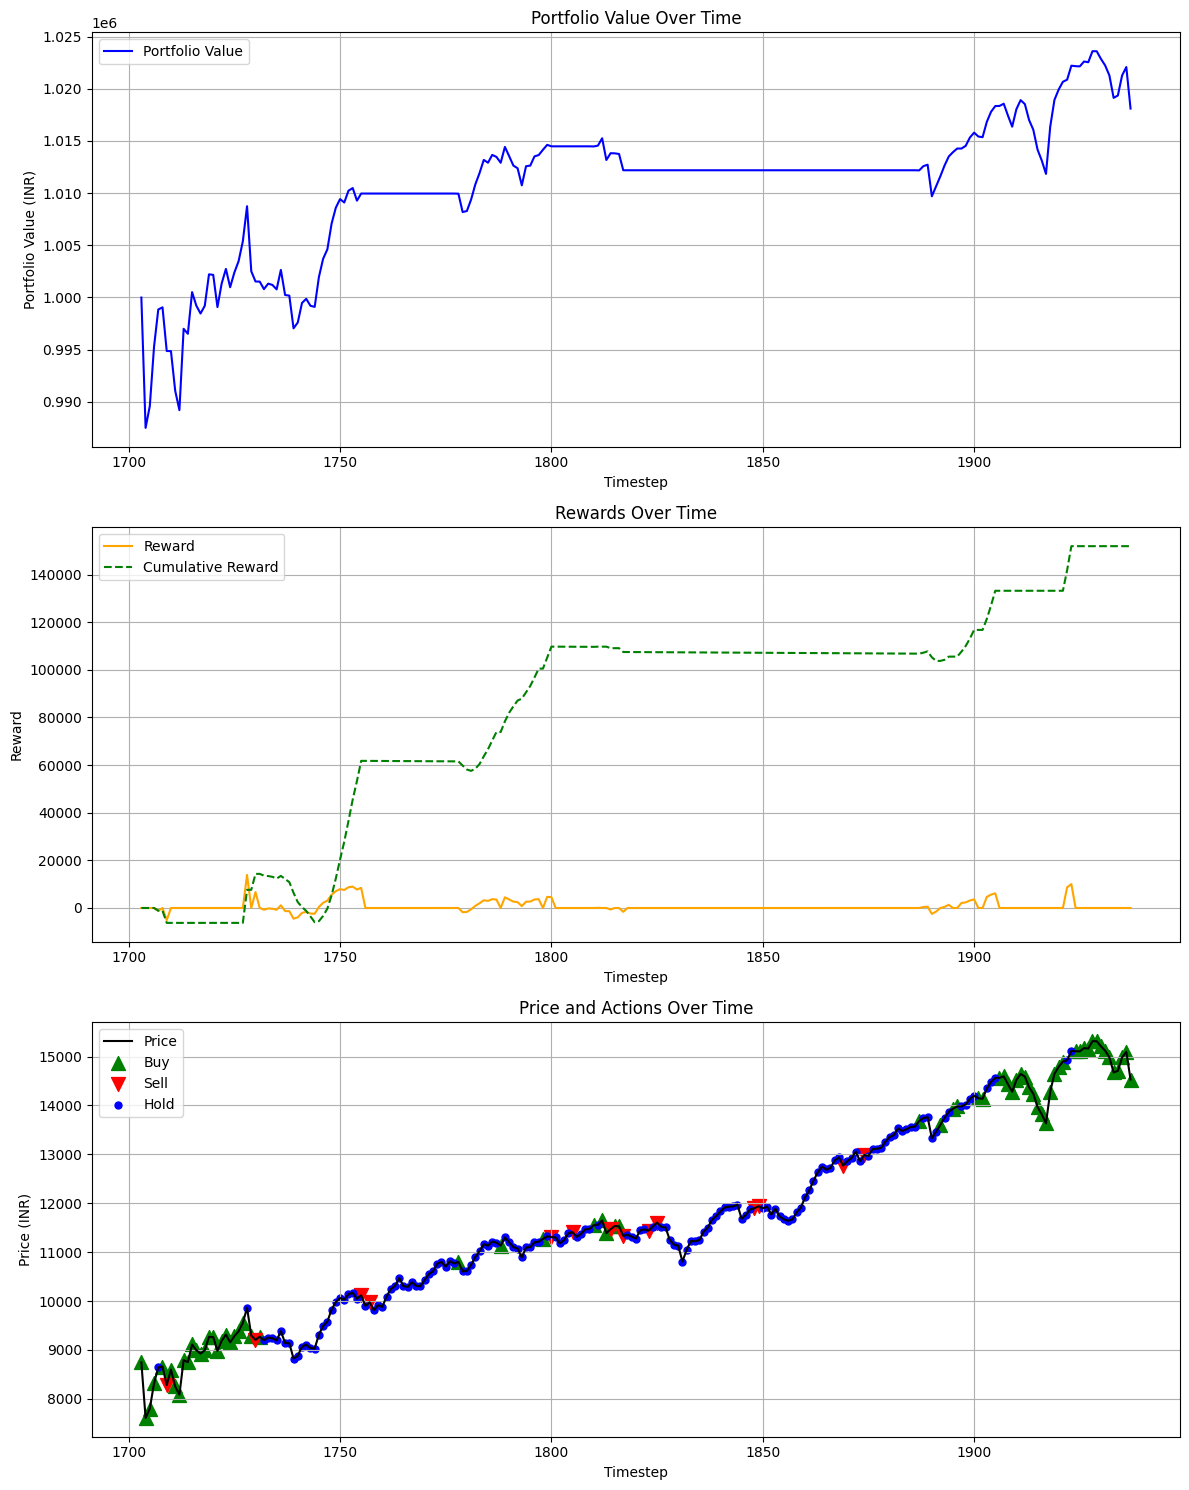

Skipping episode starting at index 2134 due to insufficient data.
Episode 410: Validation Reward = -302230.0550489662, Training Reward = 788218.3056640625
Episode 410: Validation Percentage Return = -0.03%
Episode 420: Validation Reward = -331714.0491895912, Training Reward = 408615.6142578125
Episode 420: Validation Percentage Return = -0.03%
Episode 430: Validation Reward = -264949.0394239662, Training Reward = 326272.3076171875
Episode 430: Validation Percentage Return = -0.03%
Episode 440: Validation Reward = -272044.0394239662, Training Reward = 2699396.7065429688
Episode 440: Validation Percentage Return = -0.03%
Episode 450: Validation Reward = -190383.7757520912, Training Reward = 655804.837890625
Episode 450: Validation Percentage Return = -0.03%
Episode 460: Validation Reward = -64364.55211927871, Training Reward = 181406.2919921875
Episode 460: Validation Percentage Return = -0.03%
Episode 470: Validation Reward = -37287.79918959121, Training Reward = 498220.244140625
Episod

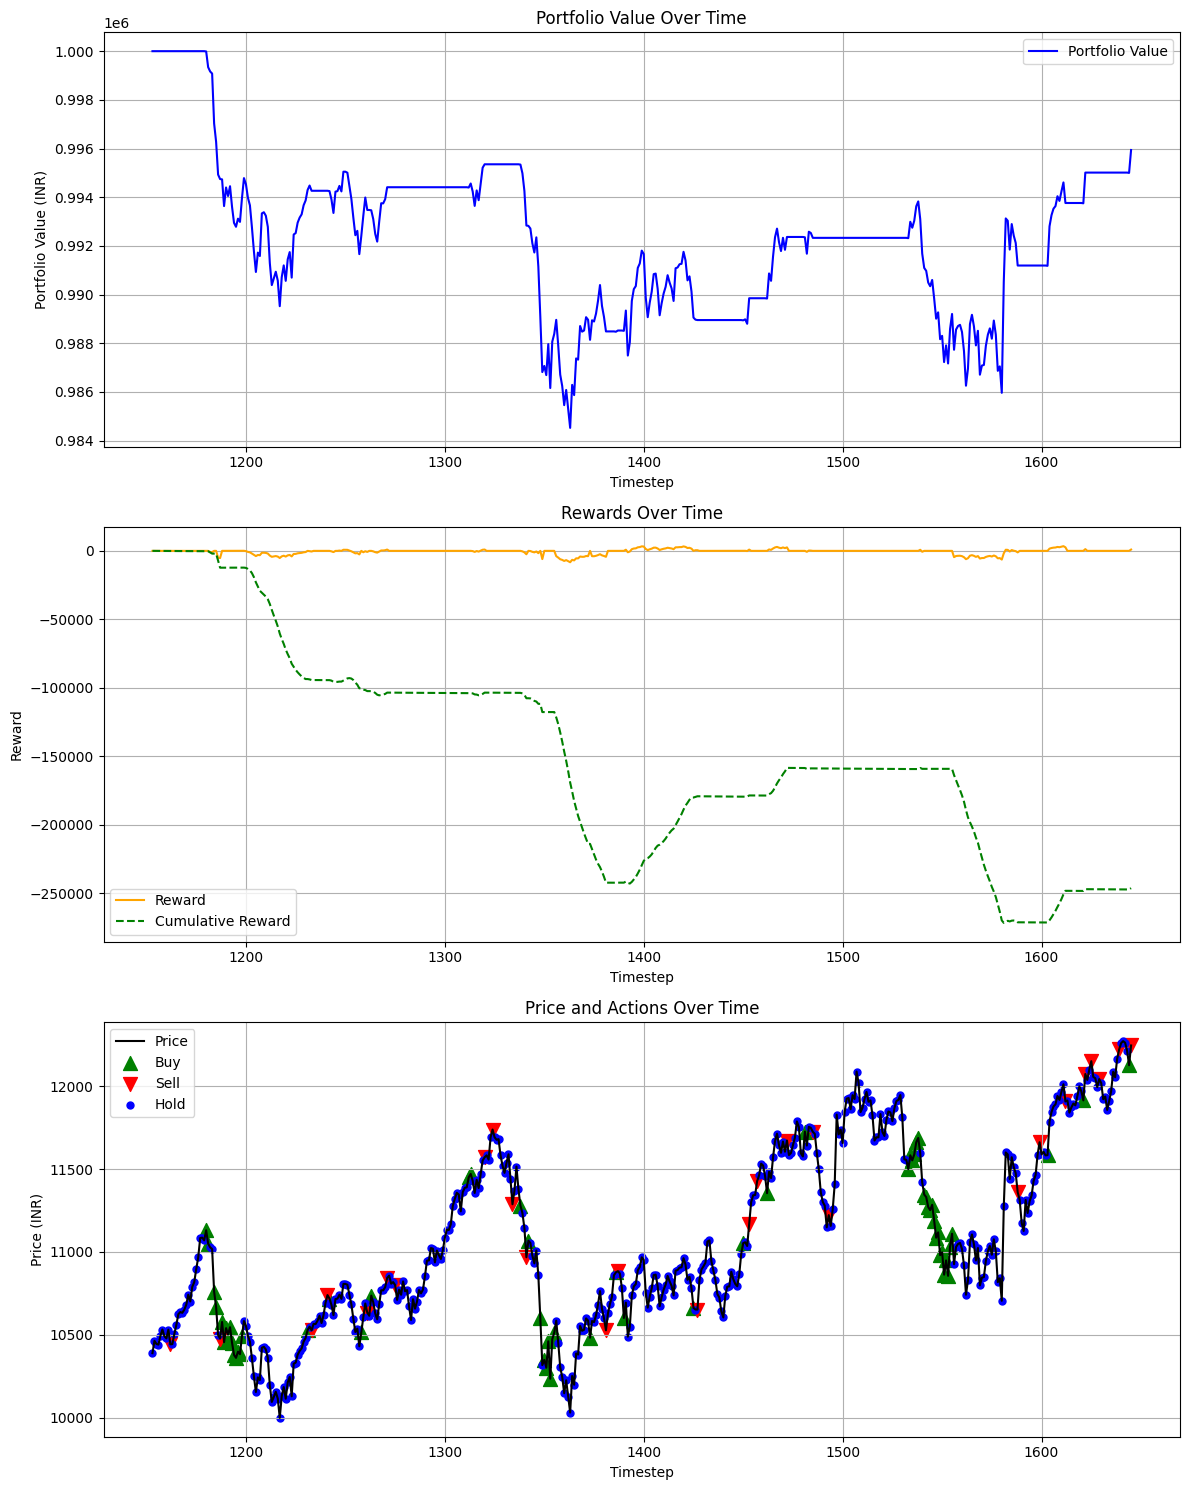

Episode 510: Validation Reward = -416529.7962599037, Training Reward = 457729.23291015625
Episode 510: Validation Percentage Return = -0.03%
Episode 520: Validation Reward = -338100.8021192787, Training Reward = 270395.955078125
Episode 520: Validation Percentage Return = -0.03%
Episode 530: Validation Reward = -185147.8138380287, Training Reward = 575014.4008789062
Episode 530: Validation Percentage Return = -0.03%
Episode 540: Validation Reward = -67587.55504896621, Training Reward = 181342.447265625
Episode 540: Validation Percentage Return = -0.03%
Skipping episode starting at index 2131 due to insufficient data.
Episode 550: Validation Reward = -377520.7972364662, Training Reward = 211543.728515625
Episode 550: Validation Percentage Return = -0.03%
Training completed or stopped. Saving final model...
Final model saved successfully.


In [25]:
# -------------------------
# 5. Training Loop
# -------------------------

for episode in range(num_episodes):

    try:
        # Reset the environment and get the initial sequence of timesteps (the state)
        state = env.reset()
    except ValueError as e:
        print(f"Episode {episode + 1}: {e}")
        print("Terminating training due to insufficient data to form any sequences.")
        break  # Exit the training loop

    total_reward = 0
    
   
    
    portfolio_value = env.initial_balance
    highest_portfolio_value = portfolio_value
    max_drawdown = 0  # Reset max_drawdown for each episode

    max_num_timesteps = env.num_timesteps

    # Validate that max_num_timesteps is positive
    if max_num_timesteps <= 0:
        print(f"Episode {episode + 1}: max_num_timesteps = {max_num_timesteps}. Skipping episode.")
        continue  # Skip to the next episode

    for t in range(max_num_timesteps):

        # Get the action using epsilon-greedy strategy
        action = get_action(state, epsilon, q_network)

        # Step the environment forward by one timestep and get the next sequence of timesteps
        next_state, reward, done, info = env.step(action)

        # Update portfolio value using the info dictionary
        portfolio_value = info.get('portfolio_value', env.initial_balance)

        # Update highest portfolio value and calculate drawdown
        highest_portfolio_value = max(highest_portfolio_value, portfolio_value)
        drawdown = (highest_portfolio_value - portfolio_value) / highest_portfolio_value
        max_drawdown = max(max_drawdown, drawdown)  # Update max drawdown for this episode

        # Store experience in replay buffer
        exp = Experience(state, action, reward, next_state, done)
        store_experience(memory_buffer, exp)

        # If max drawdown exceeds acceptable level, terminate the episode early
        if max_drawdown > acceptable_drawdown:
            print(f"Episode {episode + 1} terminated early due to excessive max drawdown ({max_drawdown:.2%}).")
            break

        # If the environment signals done, terminate the episode
        if done:
            print(f"Episode {episode + 1} terminated by environment signal.")
            break

        # Update the Q-network every NUM_STEPS_FOR_UPDATE steps
        if check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer):
            experiences, indexes, is_weights = sample_experiences(memory_buffer, batch_size, beta)
            if experiences is not None:
                # Compute TD errors
                td_errors = compute_td_error(q_network, target_q_network, experiences, gamma)
                # Update priorities in the replay buffer
                update_priorities(memory_buffer, indexes, td_errors)
                # Train the agent
                agent_learn(experiences, gamma, is_weights)

        # Move to the next state and accumulate rewards
        state = next_state
        total_reward += reward

    # Decay epsilon (exploration rate)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
        epsilon = max(epsilon, epsilon_min)  # Ensure epsilon does not go below epsilon_min

    # Increment beta towards beta_end
    beta = min(beta + beta_increment_per_episode, beta_end)

    # Evaluate model on validation data every `evaluation_interval` episodes
    if (episode + 1) % evaluation_interval == 0:
        val_reward, final_portfolio_value = evaluate_model(val_env, q_network)
        print(f"Episode {episode + 1}: Validation Reward = {val_reward}, Training Reward = {total_reward}")

        # Calculate percentage return on validation data
        percentage_return = ((final_portfolio_value - env.initial_balance) / env.initial_balance) * 100
        print(f"Episode {episode + 1}: Validation Percentage Return = {percentage_return:.2f}%")

        # Update validation rewards list and early stopping criteria
        if val_reward > best_val_reward:
            best_val_reward = val_reward
            episodes_without_improvement = 0  # Reset counter
            
        else:
            episodes_without_improvement += 1  # Increment counter if no improvement

        # Check for dynamic early stopping
        if episodes_without_improvement >= dynamic_patience:
            print(f"Early stopping triggered after {episode + 1} episodes with no improvement.")
            break

    # Render the environment every `render_interval` episodes
    if (episode + 1) % render_interval == 0:
        env.render()


# -------------------------
# Save the model after training completes or stops
# -------------------------
print("Training completed or stopped. Saving final model...")
os.makedirs('models', exist_ok=True)
q_network.save('models/q_network_final_model.keras')
print("Final model saved successfully.")

Test Reward = 788750.7716959628
Test Final Portfolio Value = 1034368.6149280274
Test Percentage Return = 3.44%


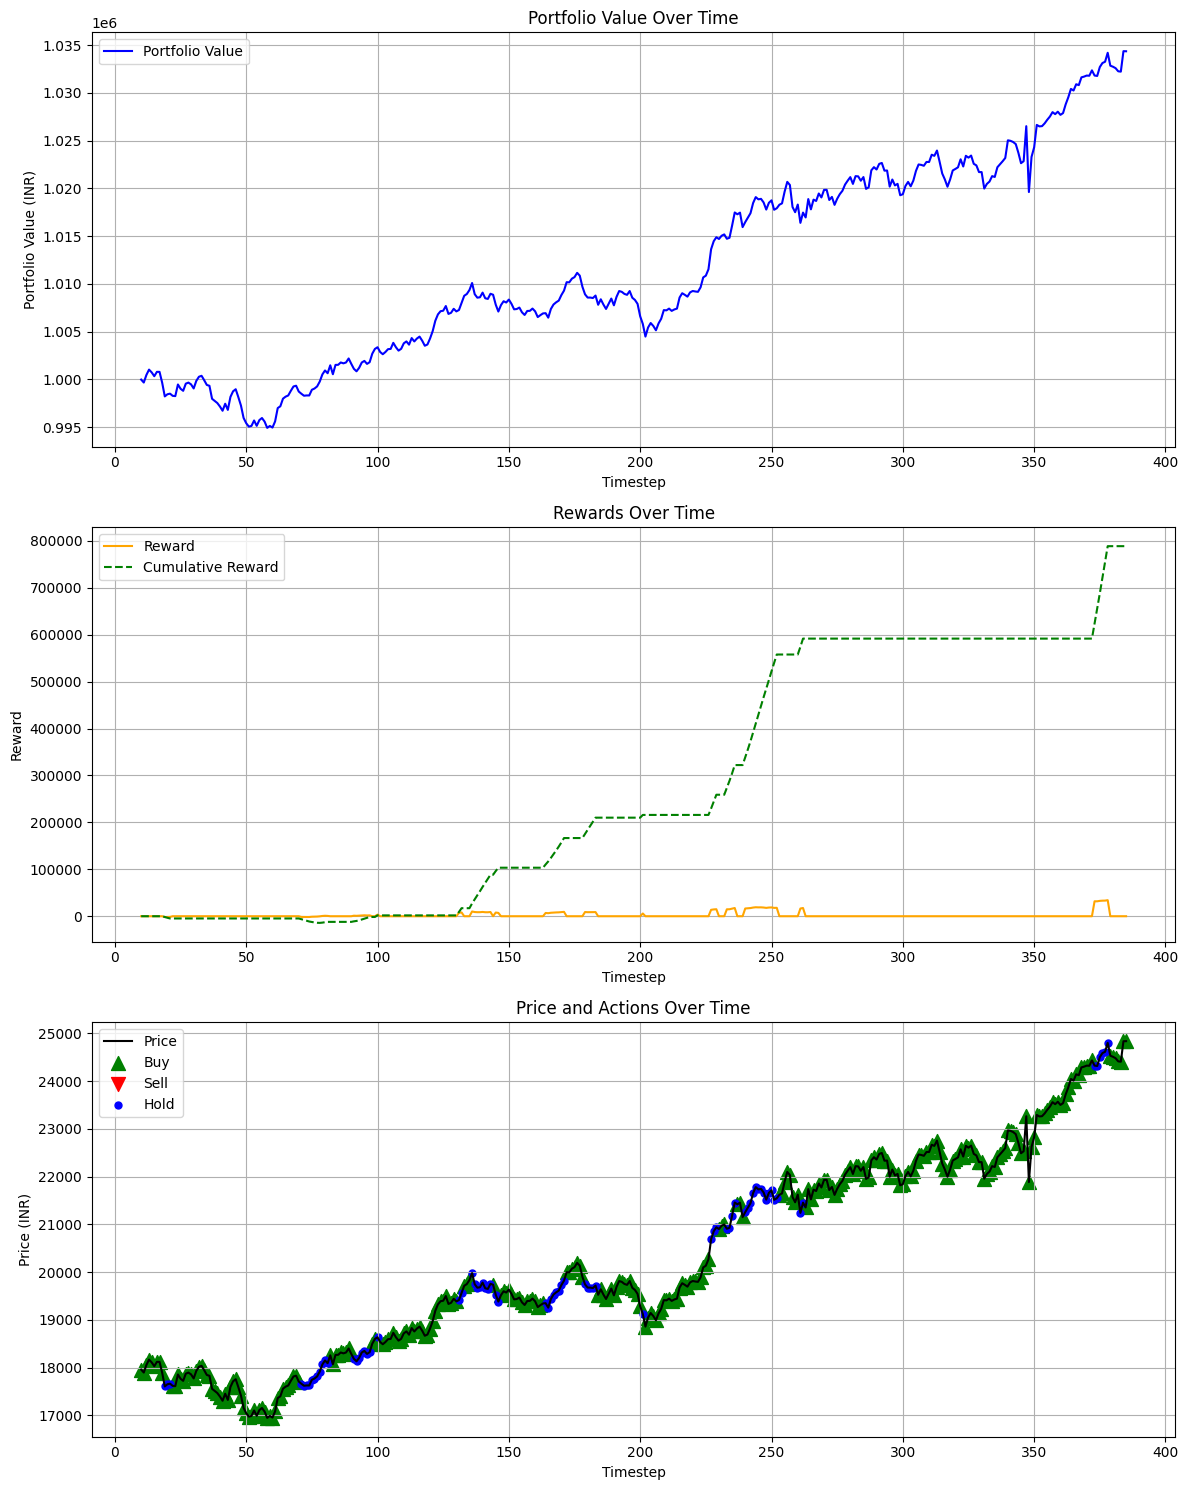

In [26]:
# -------------------------
# 6. Testing the Saved Model on Test Data
# -------------------------

# Load and preprocess the test data
test_data = data[data.index > val_end_date].copy()

# Ensure there's no overlap with validation data
assert val_data['Date'].max() < test_data.index.min(), "Validation and test data overlap!"

# Apply the same scaling to the test data
test_data[features_to_normalize] = scaler.transform(test_data[features_to_normalize])

# Reset index but keep the date as a column
test_data.reset_index(inplace=True)
test_data.rename(columns={'index': 'Date'}, inplace=True)

# Ensure 'Date' column is datetime
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Now ensure there's no overlap with validation data using 'Date' columns
assert val_data['Date'].max() < test_data['Date'].min(), "Validation and test data overlap!"

# Instantiate the test environment
test_env = TradingEnv(test_data)

# Load the best saved model

trained_q_network = tf.keras.models.load_model('models/q_network_final_model.keras')
   

# Evaluate the model on the test environment using the existing evaluate_model function

test_reward, test_final_portfolio_value = evaluate_model(test_env, trained_q_network)

# Calculate percentage return on test data
test_percentage_return = ((test_final_portfolio_value - test_env.initial_balance) / test_env.initial_balance) * 100

print(f"Test Reward = {test_reward}")
print(f"Test Final Portfolio Value = {test_final_portfolio_value}")
print(f"Test Percentage Return = {test_percentage_return:.2f}%")

# Visualize the agent's performance on the test data
test_env.render()


In [27]:
# Calculate additional performance metrics
def calculate_performance_metrics(env):
    """
    Calculate performance metrics such as Sharpe ratio and maximum drawdown.
    """
    portfolio_values = [entry['portfolio_value'] for entry in env.trading_history]
    returns = np.diff(portfolio_values)
    
    # Sharpe Ratio
    sharpe_ratio = np.mean(returns) / (np.std(returns) + 1e-9)
    
    # Maximum Drawdown
    peak = portfolio_values[0]
    max_drawdown = 0
    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    
    return sharpe_ratio, max_drawdown

# Calculate and print performance metrics
sharpe_ratio, max_drawdown = calculate_performance_metrics(test_env)
print(f"Test Sharpe Ratio = {sharpe_ratio:.4f}")
print(f"Test Maximum Drawdown = {max_drawdown:.2%}")

Test Sharpe Ratio = 0.1159
Test Maximum Drawdown = 0.67%
